In [12]:
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
import PIL.Image as Image
import torch.nn as nn
import torch.nn.functional as F
import torch
from torch import optim
import numpy as np
import json
import os

# 步驟0. 是否使用CUDA 
use_cuda = 1
device = torch.device("cuda" if (torch.cuda.is_available() & use_cuda) else "cpu")

In [13]:
# 步驟1. data loader處理 
imagepaths, labels=[],[]
for dirpath, dirlist, filenames in os.walk('./dataset/Example_finger/Train'):   
    #print(dirpath) #正在遍历的这个文件夹的本身的地址 
    #print(dirlist) #是一个 list ，内容是该文件夹中所有的目录的名字(不包括子目录)  
    #print(filenames) #是 list , 内容是该文件夹中所有的文件(不包括子目录) 
    
    fruitname = dirpath.split("\\")[-1]
    
    #print('fruitname:',fruitname)
    
    if fruitname=='Andrew':
        label = 0
    elif fruitname=='Gary':
        label = 1
    elif fruitname=='Sherry':
        label = 2
    for filename in filenames:
        imagepaths.append(os.path.join(dirpath, filename))
        labels.append(label)
    
print(imagepaths[0])
print(labels)
print(len(imagepaths))
print(len(labels))

data={}
data['imagepaths']=imagepaths
data['labels'] = labels

with open('./dataset/database/data_finger.json', 'w', newline='') as jsonfile:
    json.dump(data, jsonfile)

def my_collate(batch):
    data, target = list(), list()
    for b in batch:
        data.append(b[0])
        target.append(b[1])
    data = torch.stack(data,dim=0)
    target = torch.stack(target,dim=0)
    return data, target

class MyDataset_Fruits(torch.utils.data.Dataset):
    '''
    load the dataset
    '''
    def __init__(self,transforms):
        with open('./dataset/database/data_finger.json') as jsonfile:
            data_load = json.load(jsonfile)
            
        self.imList = data_load['imagepaths']
        self.labelList = data_load['labels']
        self.transforms=transforms
        print('number of total data:{}'.format(len(self.imList)))
    def __len__(self):
        return len(self.imList)

    def __getitem__(self, idx):
        '''
        :param idx: Index of the image file
        :return: returns the image and corresponding label file.
        '''
        image_name = self.imList[idx]
        label = self.labelList[idx]
        
        # read image with PIL module
        image = Image.open(image_name, mode='r')
        image = image.convert('RGB')
    
        
        # Convert PIL label image to torch.Tensor
        image = self.transforms(image)
        label = torch.tensor(label)
        return image, label    
    
mytransform = transforms.Compose([
            transforms.Resize((28,28)),
            transforms.ToTensor()
            ])

dataset_train = MyDataset_Fruits(transforms=mytransform)

# dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=13, num_workers=0, shuffle=False, collate_fn = my_collate)
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=30, num_workers=0, shuffle=True, collate_fn = my_collate, drop_last=False)

for data in dataloader_train:
        print(data[0].size())
        print(data[1].size())
        break

./dataset/Example_finger/Train\Andrew\F0101.bmp
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
45
45
number of total data:45
torch.Size([30, 3, 28, 28])
torch.Size([30])


In [14]:
# 步驟2. 模型宣告
class ConvM(nn.Sequential):
    def __init__(self, in_planes, out_planes, kernel_size=3, stride=1, groups=1):
        padding = (kernel_size - 1) // 2
        norm_layer = nn.BatchNorm2d
        super(ConvM, self).__init__(
            nn.Conv2d(in_planes, out_planes, kernel_size, stride, padding, groups=groups, bias=False),
            norm_layer(out_planes),
            nn.ReLU(inplace=True),
        )
class ConvNet(nn.Module):
    def __init__(self, n_class=1):
        super(ConvNet, self).__init__()
        
        self.conv = nn.Sequential(
            ConvM(3, 32, 5, 2),
            ConvM(32, 64, 5, 2),
            ConvM(64, 128, 3, 1),
            ConvM(128, 64, 3, 1),
            ConvM(64, 32, 3, 1),
           
        )        
        self.fc = nn.Linear(32, n_class)
    def forward(self, x):
        x = self.conv(x)
        x = nn.functional.adaptive_avg_pool2d(x, 1).reshape(x.shape[0], -1)
        output = self.fc(x)
        return output
# initialize the ConvNet
model_cnn = ConvNet(n_class=3).to(device)

In [15]:
# 步驟3. loss function宣告
loss = torch.nn.CrossEntropyLoss().to(device)

In [16]:
# 步驟4. optimator宣告
optimizer_cnn = optim.Adam(model_cnn.parameters(), lr=0.01)

In [17]:
# 步驟5. CNN模型開始訓練
total_epoch=100
plt_loss_train_cnn=[]
for epoch in range(total_epoch):
    # train
    model_cnn.train()     #启用 BatchNormalization 和 Dropout

    train_loss_cnn = 0
    for iteration, (data, target) in enumerate(dataloader_train):
        data, target = data.to(device), target.to(device)
        
        #print(iteration)
        #print(data)
        #print(target)

        optimizer_cnn.zero_grad()
        output_cnn = model_cnn(data)
        loss_cnn = loss(output_cnn,target) 
        train_loss_cnn += loss_cnn
        loss_cnn.backward()
        optimizer_cnn.step()     
    
    train_loss_cnn /= len(dataloader_train.dataset)
    
    plt_loss_train_cnn.append(train_loss_cnn)
   
   
    if epoch % 10 ==0:
        print('CNN[epoch: {}/{}], Average loss (Train):{:.10f}'.format(
            epoch+1, total_epoch, train_loss_cnn))
print('CNN[epoch: {}/{}], Average loss (Train):{:.10f}'.format(
            epoch+1, total_epoch, train_loss_cnn))
print('training done.')

torch.save(model_cnn,"20211001_finger_vien_cnn.pth")   #pytorch的模型保存,一般保存为pth后缀

CNN[epoch: 1/100], Average loss (Train):0.0414948426
CNN[epoch: 11/100], Average loss (Train):0.0013213875
CNN[epoch: 21/100], Average loss (Train):0.0001566018
CNN[epoch: 31/100], Average loss (Train):0.0002181737
CNN[epoch: 41/100], Average loss (Train):0.0001854731
CNN[epoch: 51/100], Average loss (Train):0.0000566520
CNN[epoch: 61/100], Average loss (Train):0.0000255274
CNN[epoch: 71/100], Average loss (Train):0.0000311149
CNN[epoch: 81/100], Average loss (Train):0.0000114858
CNN[epoch: 91/100], Average loss (Train):0.0000098092
CNN[epoch: 100/100], Average loss (Train):0.0000071145
training done.


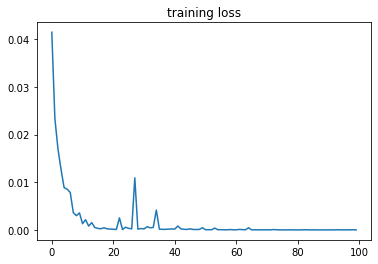

In [18]:
# 步驟6. 畫出訓練出來的loss曲線
plt.plot(plt_loss_train_cnn)
plt.title('training loss')
plt.show()


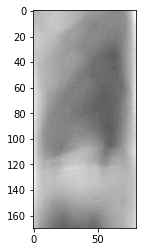

output_cnn_size: torch.Size([1, 3])
output_cnn: tensor([[1.0588e-05, 5.8723e-06, 9.9998e-01]], device='cuda:0')
output_cnn[0]_size: torch.Size([3])
output_cnn[0]: tensor([1.0588e-05, 5.8723e-06, 9.9998e-01], device='cuda:0')
CNN: probability for Andrew: 0.0011%
CNN: probability for Gary: 0.0006%
CNN: probability for Sherry: 99.9984%


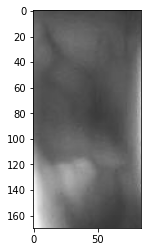

output_cnn_size: torch.Size([1, 3])
output_cnn: tensor([[2.9403e-05, 9.9994e-01, 3.1979e-05]], device='cuda:0')
output_cnn[0]_size: torch.Size([3])
output_cnn[0]: tensor([2.9403e-05, 9.9994e-01, 3.1979e-05], device='cuda:0')
CNN: probability for Andrew: 0.0029%
CNN: probability for Gary: 99.9939%
CNN: probability for Sherry: 0.0032%


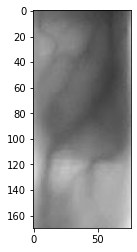

output_cnn_size: torch.Size([1, 3])
output_cnn: tensor([[9.9970e-01, 1.5937e-04, 1.3867e-04]], device='cuda:0')
output_cnn[0]_size: torch.Size([3])
output_cnn[0]: tensor([9.9970e-01, 1.5937e-04, 1.3867e-04], device='cuda:0')
CNN: probability for Andrew: 99.9702%
CNN: probability for Gary: 0.0159%
CNN: probability for Sherry: 0.0139%


In [19]:
# 步驟7. 辨識指靜脈圖片
model_cnn = torch.load("20211001_finger_vien_cnn.pth") #pytorch的模型的加载

model_cnn.eval()  #不启用 BatchNormalization 和 Dropout，
                  #保证BN和dropout不发生变化，pytorch框架会自动把BN和Dropout固定住，
                  #不会取平均，而是用训练好的值，不然的话，一旦test的batch_size过小，很容易就会被BN层影响结果

image_names = ['./dataset/Example_finger/Test/F0310.bmp',
              './dataset/Example_finger/Test/F0210.bmp',
              './dataset/Example_finger/Test/F0110.bmp']
for image_name in image_names:
    image = Image.open(image_name, mode='r') #依序打開image_names路徑裡的圖片
    
    #print(image.mode)
   
    image = image.convert('RGB')
    
    #print(image.mode)
    
    plt.imshow(image)#函数负责对图像进行处理，并显示其格式
    plt.show()#则是将plt.imshow()处理后的函数图像显示出来。   
    
    image = mytransform(image)
    
    #print("image_size:",image.shape)
    
    with torch.no_grad():   #在该模块下，所有计算得出的tensor的requires_grad都自动设置为False
                            #当requires_grad设置为False时,反向传播时就不会自动求导了，因此大大节约了显存或者说内存
        
        output_cnn = torch.unsqueeze(image,dim=0)  #torch.unsqueeze()这个函数主要是对数据维度进行扩充。需要通过dim指定位置
                                                   #，给指定位置加上维数为1的维度
        
        #print("output_cnn_size:", output_cnn.shape)
        #print("output_cnn:", output_cnn)
        
        output_cnn = model_cnn(output_cnn.to(device))   #進行卷積特徵擷取及匹配    
        
        #print("output_cnn_size:", output_cnn.shape)
        #print("output_cnn:", output_cnn)
  
    output_cnn= F.softmax(output_cnn,dim=1)            #算出此圖屬於那類的百分比機率
    
    print("output_cnn_size:", output_cnn.shape)
    print("output_cnn:", output_cnn)
    
    print("output_cnn[0]_size:", output_cnn[0].shape)
    print("output_cnn[0]:", output_cnn[0])
    
    list_class = ['Andrew','Gary','Sherry'] 
    
    for i, tmp_out in enumerate(output_cnn[0]):
        print('CNN: probability for {}: {:.4f}%'.format(list_class[i], tmp_out*100))